In [82]:
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pytensor.tensor as pt
import scipy.stats.mstats as mstats
%matplotlib inline
import arviz as az
from IPython.core.pylabtools import figsize

In [11]:
data = np.genfromtxt("Chapter2_MorePyMC/data/challenger_data.csv",skip_header=1,usecols=[1,2], delimiter = ",")

In [20]:
challenger_data = data[~np.isnan(data[:,1])]

In [37]:
temperature = challenger_data[:,0]
odata = challenger_data[:,1]

In [38]:
challenger_data

array([[66.,  0.],
       [70.,  1.],
       [69.,  0.],
       [68.,  0.],
       [67.,  0.],
       [72.,  0.],
       [73.,  0.],
       [70.,  0.],
       [57.,  1.],
       [63.,  1.],
       [70.,  1.],
       [78.,  0.],
       [67.,  0.],
       [53.,  1.],
       [67.,  0.],
       [75.,  0.],
       [70.,  0.],
       [81.,  0.],
       [76.,  0.],
       [79.,  0.],
       [75.,  1.],
       [76.,  0.],
       [58.,  1.]])

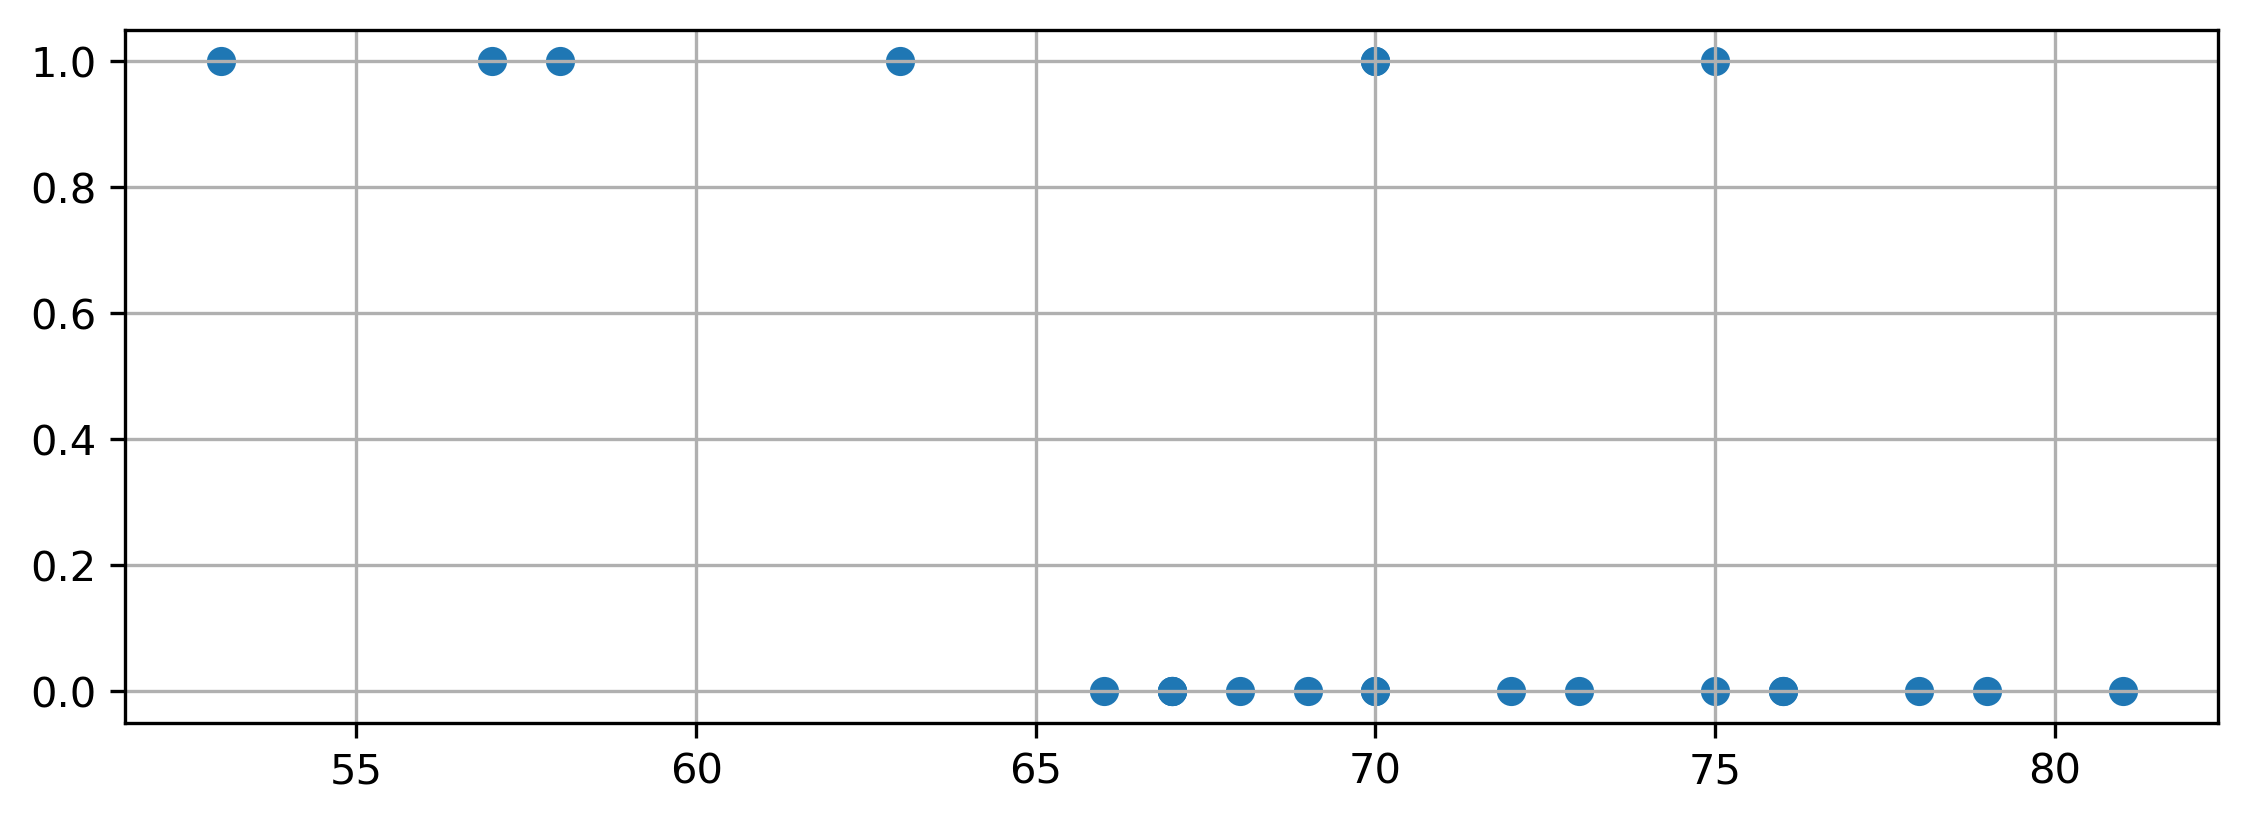

In [35]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (9, 3), dpi = 300)
axes.grid()
axes.scatter(challenger_data[:,0], challenger_data[:,1])

## Logistic Prior 

$$ f_X(x) = \frac{1}{1+e^{\alpha + \beta x}} $$

In [44]:
with pm.Model() as model:
    alpha = pm.Normal("alpha", mu = 0, tau = 0.001, initval = 0)
    beta = pm.Normal("beta", mu = 0, tau = 0.001, initval = 0)
    logistic = pm.Deterministic("logistic", 1./(1 + pt.exp(alpha + beta*temperature)))

In [45]:
with model:
    obs = pm.Bernoulli("bern_ob", logistic, observed = odata)

    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, initvals=start)

/home/sab/miniconda3/envs/jupyter/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]


/home/sab/miniconda3/envs/jupyter/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 112_137 draw iterations (4_000 + 448_548 draws total) took 228 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [46]:
alpha_samples = np.concatenate(trace.posterior.alpha.data[:,100000::2])[:, None]  # best to make them 1d
beta_samples = np.concatenate(trace.posterior.beta.data[:,100000::2])[:, None]

In [51]:
alpha_samples.mean(), beta_samples.mean()

(-15.688292746283707, 0.24264651661177436)

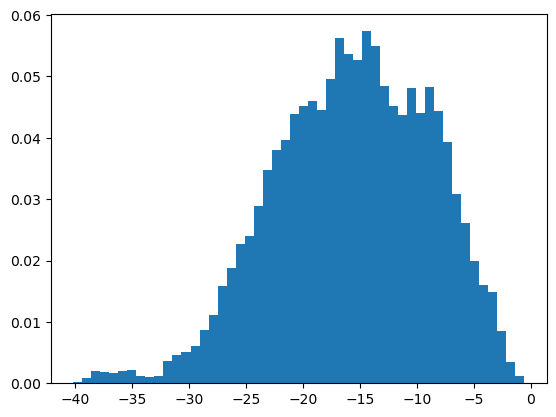

In [49]:
plt.hist(alpha_samples, bins = 50, density = True);

<Axes: title={'center': 'alpha'}>

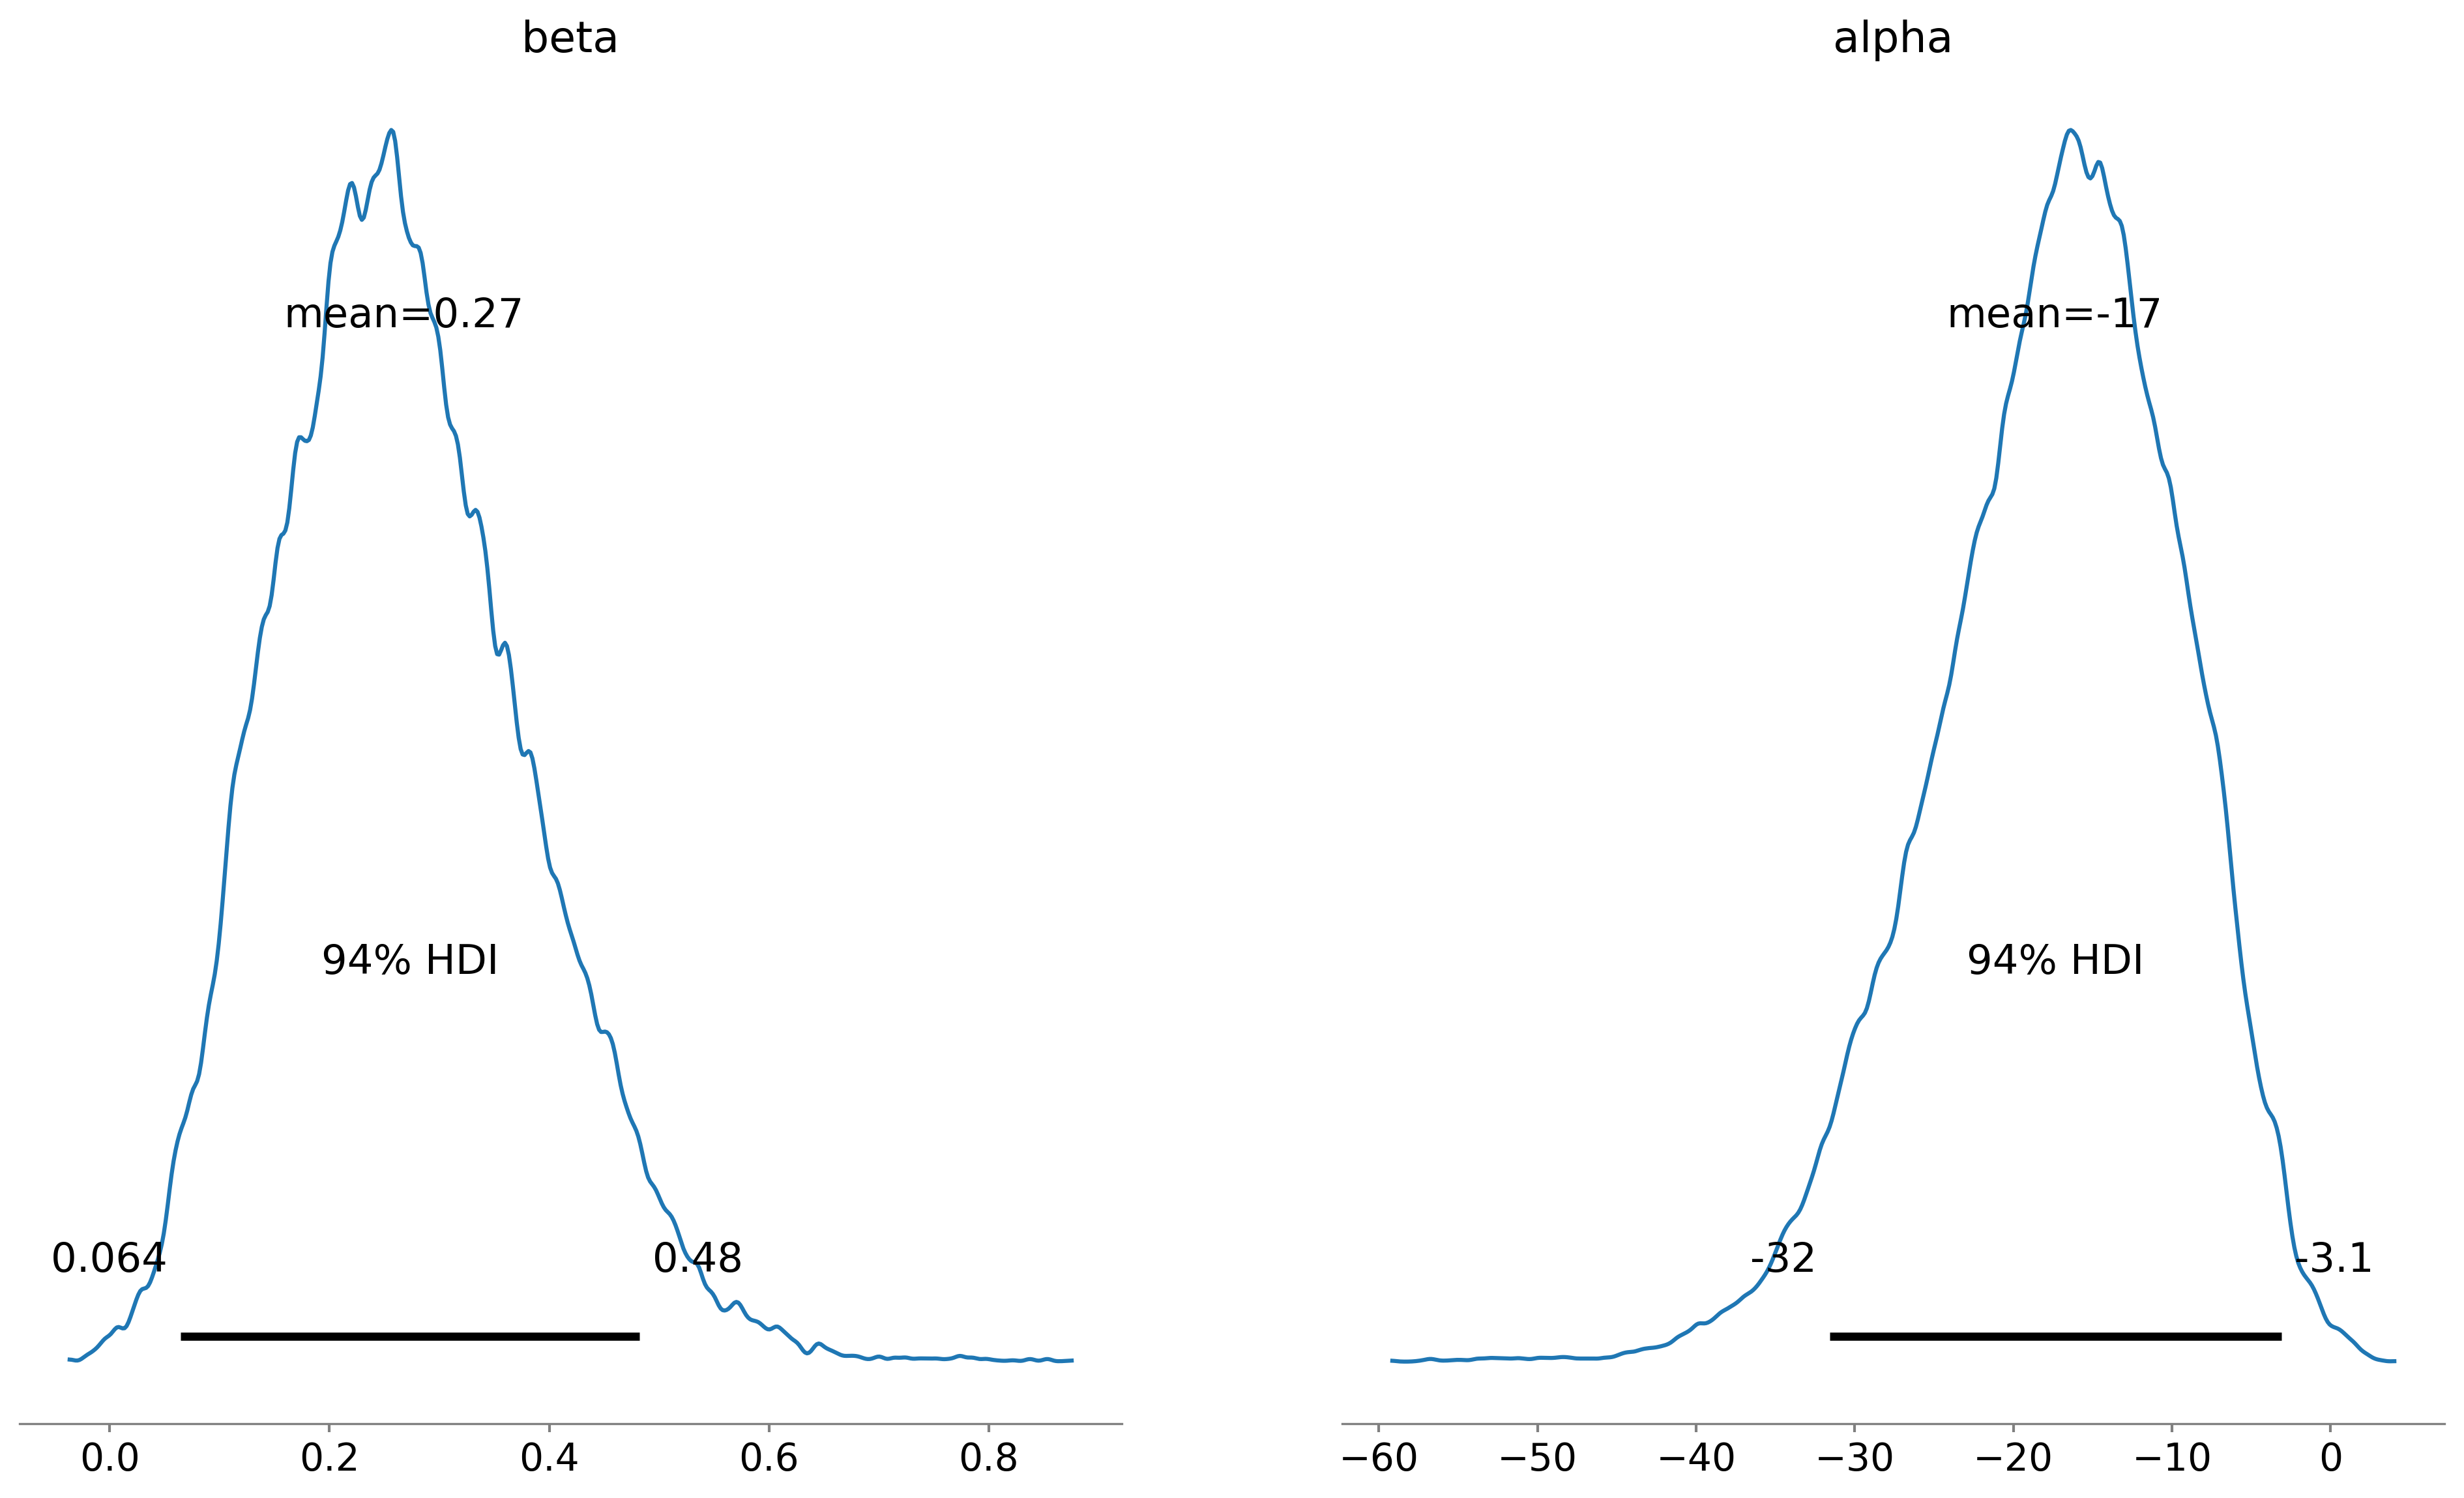

In [59]:
fig, axes = plt.subplots(1, 2, figsize = (16, 9), dpi = 300)
az.plot_posterior(trace, var_names=['beta'], ax = axes[0])
az.plot_posterior(trace, var_names=['alpha'], ax = axes[1])

In [92]:
def logst(x, alpha, beta):
    return 1./(1. + np.exp(alpha + beta * x))
t = np.linspace(temperature.min() - 5, temperature.max()+5, 50)[:, None]

In [77]:
p_t = logst(t,alpha_samples, beta_samples)
p_min_t = logst(t, alpha_samples.min(), beta_samples.min())
p_max_t = logst(t, alpha_samples.max(), beta_samples.max())

In [78]:
ptmean = p_t.mean(axis = 0)

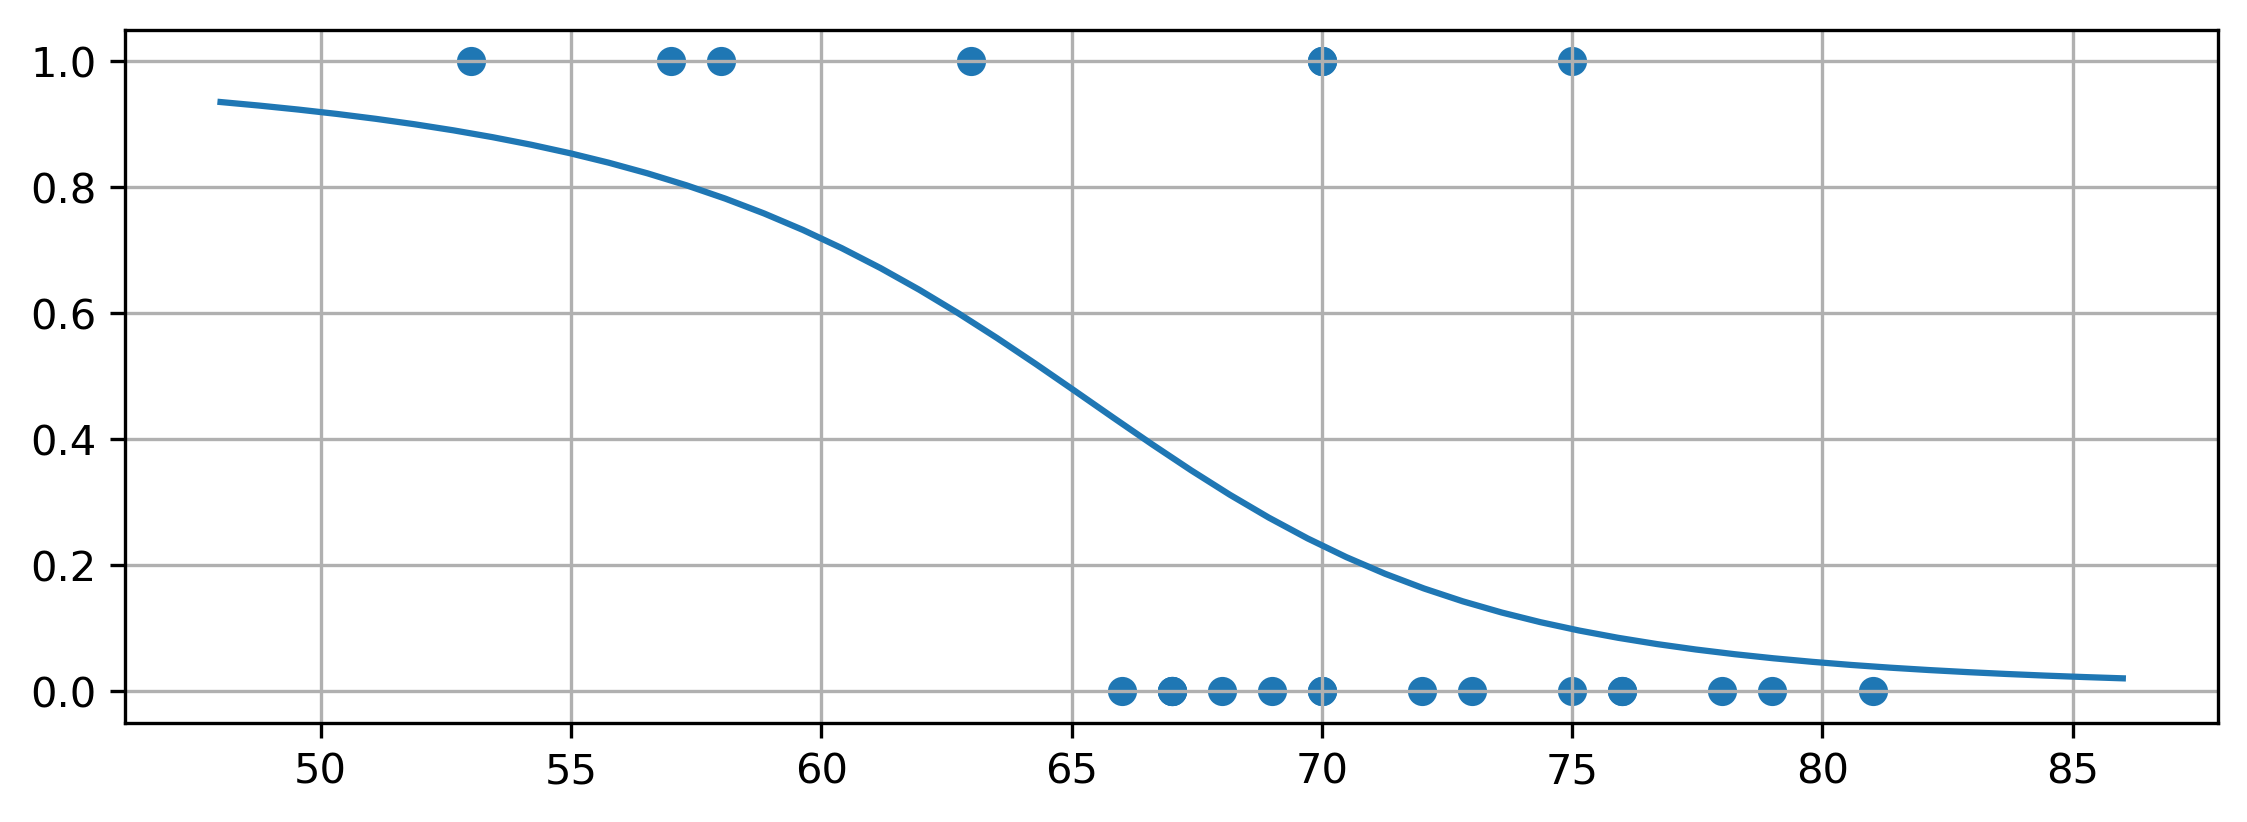

In [81]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (9, 3), dpi = 300)
axes.grid()
axes.scatter(challenger_data[:,0], challenger_data[:,1])
axes.plot(t, ptmean)

In [96]:
qs = mstats.mquantiles(p_t, [0.025, 97.5], axis=0)

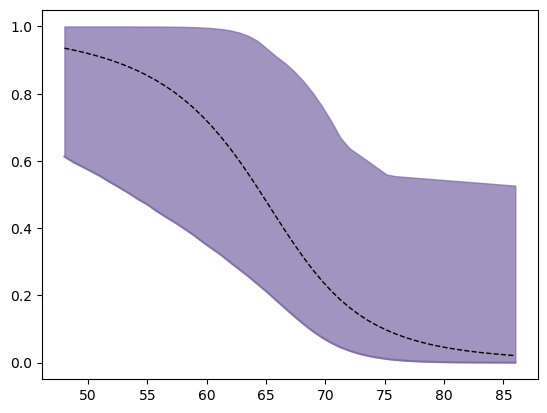

In [99]:
plt.fill_between(t[:,0], *qs, alpha=0.7, color="#7A68A6")
plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)
plt.plot(t, ptmean, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")